In [405]:
# Gregor von Laszewski laszewski@gmail.com

In [406]:
import pandas.errors

from cloudmesh.common.util import readfile
from glob import glob
from cloudmesh.common.Shell import Shell
from cloudmesh.common.FlatDict import FlatDict
import sys
from io import StringIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import traceback
from pprint import pprint
import ast

# dirname = "data/project.2/*/*.out"
dirname = "data/project.2/*/*.out"
files = glob(dirname)



print (files)

['data/project.2\\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_100_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1\\a100-100-1-cloudmask-thf2bn-51472126.out', 'data/project.2\\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_10_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1\\a100-10-1-cloudmask-thf2bn-51472122.out', 'data/project.2\\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_2_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1\\a100-2-1-cloudmask-thf2bn-51472121.out', 'data/project.2\\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_30_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1\\a100-30-1-cloudmask-thf2bn-51472123.out', 'data/project.2\\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_50_seed_1

In [407]:
def get(value):
    return float(df[df['timer'] == value]["time"])


data = []
new_dataframe = pd.DataFrame()

for filename in files:
    print (filename)
    content = readfile(filename)
    yaml = os.path.join(os.path.dirname(filename), 'config.yaml')
    config = FlatDict()
    config.loadf(filename=yaml)
    job_id = os.path.splitext(os.path.basename(filename))[0].split('-')[-1]

    # mllog_lines = Shell.find_lines_with(content, '"key": "result"')
    mllog_lines = "\n".join(Shell.find_lines_with(content, ':::MLLOG '))
    mllog_lines = mllog_lines.replace(':::MLLOG ', '')
    lines = Shell.find_lines_from(content, "# inference")
    lines = Shell.find_lines_with(lines, "# csv")
    content = "\n".join(lines)
    try:
        #print (content)
        # df = pd.read_csv(content)
        df = pd.read_csv(StringIO(content), sep=",")

        df = df.drop(columns=["# csv", "status", "sum", "start", "uname.node", "user",
                              "uname.system", "platform.version", "msg", "tag"])
        for exclude in ["init",'number_of_ranks', "number_of_nodes", "version",
                        "result", "run_stop", "submission_status"]:
            df = df[df['timer'] != exclude]
        for key in ['epoch', 'card_name', 'repeat']:
            df[key] = config[f'experiment.{key}']

        df['jobid'] = job_id

        # df = df.drop(rows=["init"])

        df['time'] = df['time'].astype(float)
        # display(df)
        # add mllog entry

        if len(mllog_lines) > 0:
            print('i see mllog lines')
        else:
            continue

        # print(len(mllog_lines))

        for mllog_line in mllog_lines.splitlines():

            current_dict = eval(mllog_line)
            if current_dict['key'] != 'result':
                continue

            # if 'key' not in current_dict:
            # pprint(current_dict)

                    # Extracting values
            value = eval(current_dict['value'])

            f = FlatDict(sep='.')
            f.load(value)

            mllog_col_names = ['training.samples', 'training.accuracy', 'training.loss', 'training.val_loss', 'training.val_accuracy', 'training.history.accuracy', 'training.history.loss', 'training.history.val_loss', 'training.history.val_accuracy', 'inference.avg_accuracy', 'inference.accuracy', 'inference_analyze.number', 'inference_analyze.bs', 'inference_analyze.nodes', 'inference_analyze.gpus', 'inference_analyze.time_per_inference']
            mllog_dict = {}
            for key in mllog_col_names:
                mllog_dict[key] = f[key]
            for key in mllog_dict.keys():
                df[key] = str(f[key])
            # try:
            # df['train.accuracy'] = value["training"]["history"]["accuracy"]
            # print(train_acc)
            # df['train.loss'] = value["training"]["history"]["loss"]
            # df['val.accuracy'] = value["training"]["history"]["val_accuracy"]
            # df['val.loss'] = value["training"]["history"]["val_loss"]
            # df['test.accuracy'] = value["inference"]["avg_accuracy"]
            # print(mllog_dict)
            # except ValueError:
            #     print('length mismatch.')
            # for key in current_dict.keys():
            #     df[key] = current_dict[key]

        total = get("total")
        training = get("training block")
        inference = get("inference block")

        #df[["rest"]] = ["rest", 0.0]

        # rest = total - training - inference
        # rest_row = pd.DataFrame([{'timer':'rest', 'time': rest}])

        # df = pd.concat([df, rest_row], ignore_index=True)
        # df = pd.concat([rest_row,df.loc[:]]).reset_index(drop=True)

        # df[["job"]] = filename.replace(".out","").replace("outputs/", "")
        df[["job"]] = os.path.splitext(os.path.basename(filename))[0]
        # display(df)

        df = df.reset_index()
        df = df.drop(columns=["index"])
        #display(df)
        #print (total, training, inference)
        df.reset_index(drop=True, inplace=True)
        data.append(df)
        # new_dataframe = pd.concat([new_dataframe, df]).reset_index(drop=True)
        new_dataframe = pd.concat([new_dataframe,df]).reset_index(drop=True)
    except pd.errors.EmptyDataError as e:
        # print(content)
        # print(traceback.format_exc())
        print(f"ERROR: {filename}")

data/project.2\card_name_a100_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_100_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1\a100-100-1-cloudmask-thf2bn-51472126.out
i see mllog lines
type load

{'name': 'cloudmask', 'training': {'samples': 970, 'accuracy': 0.8883432745933533, 'loss': 0.25227054953575134, 'val_loss': 0.2691647410392761, 'val_accuracy': 0.8829081058502197, 'history': {'accuracy': [0.799124538898468, 0.7971333265304565, 0.8046467304229736, 0.8110162615776062, 0.8093166947364807, 0.8159724473953247, 0.8134312629699707, 0.8118912577629089, 0.8232197165489197, 0.8274263739585876, 0.8300381898880005, 0.8303179144859314, 0.8282119631767273, 0.8396173119544983, 0.8420331478118896, 0.846721887588501, 0.8502042889595032, 0.8574312329292297, 0.8576148748397827, 0.8585497736930847, 0.8564696907997131, 0.8613337874412537, 0.8628745079040527, 0.8565517067909241, 0.8574615716934204, 0.8599830865859985, 0.8639953136444092, 0.8

In [408]:
new_dataframe

,timer,time,epoch,card_name,repeat,jobid,training.samples,training.accuracy,training.loss,training.val_loss,...,training.history.val_loss,training.history.val_accuracy,inference.avg_accuracy,inference.accuracy,inference_analyze.number,inference_analyze.bs,inference_analyze.nodes,inference_analyze.gpus,inference_analyze.time_per_inference,job
0,total,4301.555,100,a100,1,51472126,970,0.8883432745933533,0.25227054953575134,0.2691647410392761,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.8858093222222224,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
1,training block,4156.877,100,a100,1,51472126,970,0.8883432745933533,0.25227054953575134,0.2691647410392761,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.8858093222222224,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
2,training,4156.875,100,a100,1,51472126,970,0.8883432745933533,0.25227054953575134,0.2691647410392761,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.8858093222222224,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
3,loaddata,4.857,100,a100,1,51472126,970,0.8883432745933533,0.25227054953575134,0.2691647410392761,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.8858093222222224,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
4,training_on_mutiple_GPU,4151.475,100,a100,1,51472126,970,0.8883432745933533,0.25227054953575134,0.2691647410392761,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.8858093222222224,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,training_on_mutiple_GPU,8922.666,70,rtx2080,1,51472145,970,0.885524332523346,0.2577199935913086,0.2677246034145355,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.8845280000000001,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
167,inference block,92.558,70,rtx2080,1,51472145,970,0.885524332523346,0.2577199935913086,0.2677246034145355,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.8845280000000001,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
168,inference,0.011,70,rtx2080,1,51472145,970,0.885524332523346,0.2577199935913086,0.2677246034145355,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.8845280000000001,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
169,load model,0.249,70,rtx2080,1,51472145,970,0.885524332523346,0.2577199935913086,0.2677246034145355,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.8845280000000001,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145


In [409]:
print(list(new_dataframe.columns))
for key in list(new_dataframe.columns):
    dont_convert = ['timer', 'card_name', 'job']
    convert_to_list = ['training.history.accuracy', 'training.history.loss', 'training.history.val_loss', 'training.history.val_accuracy', 'inference.accuracy']
    convert_to_int = ['repeat', 'training.samples', 'inference_analyze.number', 'inference_analyze.bs', 'inference_analyze.nodes', 'inference_analyze.gpus', 'epoch', 'jobid']


    if key in convert_to_list:
        # new_dataframe[key] = df[key].apply(convert_to_list)
        # df['col1'] = df['col1'].apply(complex_function)
        continue
    elif key in convert_to_int:
        new_dataframe[key] = new_dataframe[key].astype(int)
        continue
    # elif key not in dont_convert:
    #     new_dataframe[key] = new_dataframe[key].astype(float)
    #     continue
    # elif key in dont_convert:
    #     continue

convert_to_float = ['training.accuracy', 'training.loss', 'training.val_loss', 'training.val_accuracy', 'inference.avg_accuracy', 'inference_analyze.time_per_inference']
for column in convert_to_float:
    new_dataframe[column] = new_dataframe[column].astype(float)
for column in convert_to_list:
    new_dataframe[column] = new_dataframe[column].apply(lambda x: ast.literal_eval(x))
# new_dataframe['time'] = new_dataframe['time'].astype(float)
new_dataframe

['timer', 'time', 'epoch', 'card_name', 'repeat', 'jobid', 'training.samples', 'training.accuracy', 'training.loss', 'training.val_loss', 'training.val_accuracy', 'training.history.accuracy', 'training.history.loss', 'training.history.val_loss', 'training.history.val_accuracy', 'inference.avg_accuracy', 'inference.accuracy', 'inference_analyze.number', 'inference_analyze.bs', 'inference_analyze.nodes', 'inference_analyze.gpus', 'inference_analyze.time_per_inference', 'job']


,timer,time,epoch,card_name,repeat,jobid,training.samples,training.accuracy,training.loss,training.val_loss,...,training.history.val_loss,training.history.val_accuracy,inference.avg_accuracy,inference.accuracy,inference_analyze.number,inference_analyze.bs,inference_analyze.nodes,inference_analyze.gpus,inference_analyze.time_per_inference,job
0,total,4301.555,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
1,training block,4156.877,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
2,training,4156.875,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
3,loaddata,4.857,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
4,training_on_mutiple_GPU,4151.475,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100-100-1-cloudmask-thf2bn-51472126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,training_on_mutiple_GPU,8922.666,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
167,inference block,92.558,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
168,inference,0.011,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145
169,load model,0.249,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080-70-1-cloudmask-thf2bn-51472145


In [410]:
def simplify_job(name):
   return " ".join(name.split("-")[:-2]).replace("fox", "dgx")
# display(df)
# df['job_simple'] = df['job'].apply(lambda name: " ".join(name.split("-")[:-2]).replace("fox", "special"))

new_dataframe['job'] = new_dataframe['job'].apply(simplify_job)
new_dataframe

,timer,time,epoch,card_name,repeat,jobid,training.samples,training.accuracy,training.loss,training.val_loss,...,training.history.val_loss,training.history.val_accuracy,inference.avg_accuracy,inference.accuracy,inference_analyze.number,inference_analyze.bs,inference_analyze.nodes,inference_analyze.gpus,inference_analyze.time_per_inference,job
0,total,4301.555,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100 100 1 cloudmask
1,training block,4156.877,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100 100 1 cloudmask
2,training,4156.875,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100 100 1 cloudmask
3,loaddata,4.857,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100 100 1 cloudmask
4,training_on_mutiple_GPU,4151.475,100,a100,1,51472126,970,0.888343,0.252271,0.269165,...,"[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44,a100 100 1 cloudmask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,training_on_mutiple_GPU,8922.666,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080 70 1 cloudmask
167,inference block,92.558,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080 70 1 cloudmask
168,inference,0.011,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080 70 1 cloudmask
169,load model,0.249,70,rtx2080,1,51472145,970,0.885524,0.257720,0.267725,...,"[0.410442978143692, 0.39439356327056885, 0.407...","[0.7685412168502808, 0.7786415815353394, 0.771...",0.884528,"[0.8976655555555556, 0.8677983333333333, 0.908...",100,32,1,1,0.93,rtx2080 70 1 cloudmask


In [411]:

# def get_by_timer(data, timer):
#     d = data[data['timer'] == timer]
#     d = d.reset_index()
#     d["job"] = d["job"].apply(simplify_job)
#     d = d.drop(columns=["index"])
#     return d
#
# total = get_by_timer(data, "total")
#
# total

In [412]:
cols = list(new_dataframe.columns)
cols.insert(0, cols.pop(cols.index('job')))
new_dataframe = new_dataframe[cols]
print(new_dataframe.columns)
full_df = new_dataframe.copy()


Index(['job', 'timer', 'time', 'epoch', 'card_name', 'repeat', 'jobid',
       'training.samples', 'training.accuracy', 'training.loss',
       'training.val_loss', 'training.val_accuracy',
       'training.history.accuracy', 'training.history.loss',
       'training.history.val_loss', 'training.history.val_accuracy',
       'inference.avg_accuracy', 'inference.accuracy',
       'inference_analyze.number', 'inference_analyze.bs',
       'inference_analyze.nodes', 'inference_analyze.gpus',
       'inference_analyze.time_per_inference'],
      dtype='object')


In [413]:
def save_image(p, name, dpi=300):
    # Shell.mkdir(directory)
    plt.savefig(f"{name}.svg", bbox_inches="tight")
    plt.savefig(f"{name}.png", bbox_inches="tight", dpi=dpi)
    plt.savefig(f"{name}.pdf", bbox_inches="tight")
    plt.savefig(f"{name}.tiff", bbox_inches="tight")

['a100' 'k80' 'p100' 'rtx2080']


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

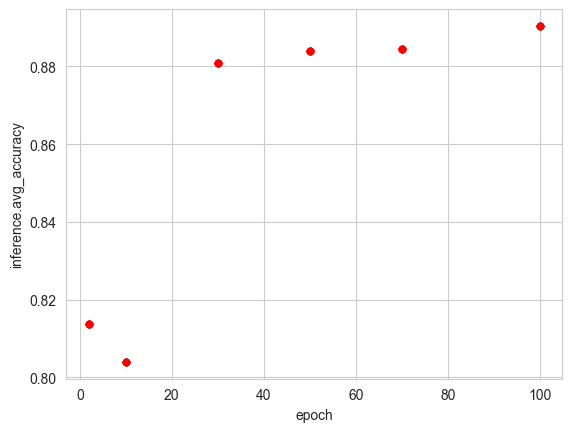

In [414]:

# get all the lines from one of the values below
# if we plot all four values
# epoch inferece.accuracy card_name == a100
print(new_dataframe['card_name'].unique())
for gpu in new_dataframe['card_name'].unique():
    plt.clf()
    # Set the figure size
    plt.figure(figsize=(8, 6))  # Adjust the width and height as needed
    subset = new_dataframe.loc[new_dataframe['card_name'] == gpu]
    subset.plot(kind='scatter',
        x='epoch',
        y='inference.avg_accuracy',
        color='red')

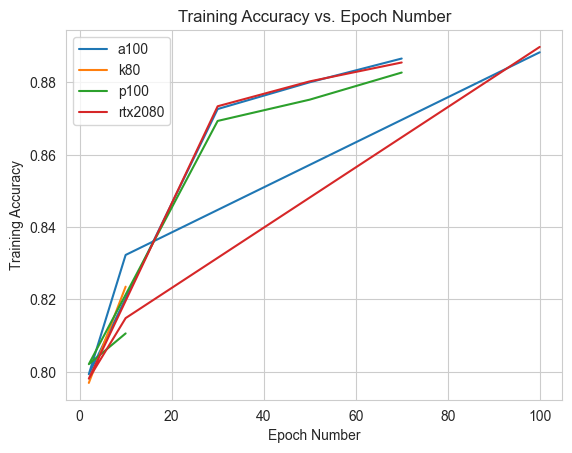

In [415]:
unique_card_names = new_dataframe['card_name'].unique()

# Plotting each card_name separately
for card_name in unique_card_names:
    subset = new_dataframe[new_dataframe['card_name'] == card_name]
    x = subset['epoch']  # Assuming the index represents the epoch number
    y = subset['training.accuracy']
    plt.plot(x, y, label=card_name)

# Set the labels and title
plt.xlabel('Epoch Number')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epoch Number')

# Add a legend
plt.legend()

# Show the plot
plt.show()

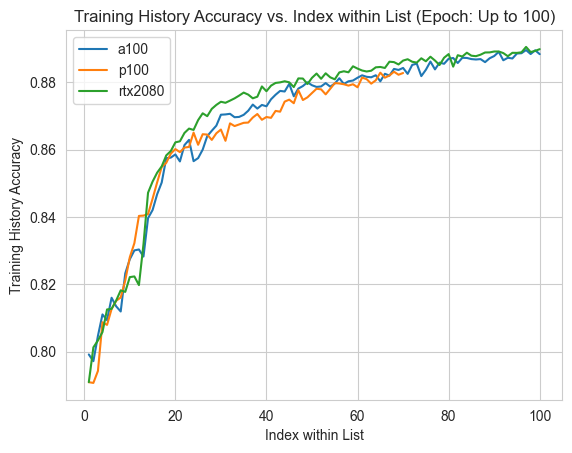

In [416]:
epoch = 100
card_name = 'a100'
repeat = 1
# Plotting each card_name separately
# for card_name in unique_card_names:

def create_accuracy_history_plot(card_name, epoch, repeat):

    subset = new_dataframe[(new_dataframe['card_name'] == card_name) & (new_dataframe['epoch'] == epoch) & (new_dataframe['repeat'] == repeat)]
    # display(subset)
    y = subset['training.history.accuracy'].values[0]  # Extracting the list of accuracy values
    x = range(1, len(y) + 1)  # x-axis represents the index within the list (1-100)
    plt.plot(x, y, label=card_name)

    # Set the labels and title
    plt.xlabel('Index within List')
    plt.ylabel('Training History Accuracy')
    plt.title('Training History Accuracy vs. Index within List (Epoch: Up to {})'.format(epoch))

    # Add a legend
    # plt.legend()

    # Show the plot
    # plt.show()
create_accuracy_history_plot(card_name='a100', epoch=100, repeat=1)
create_accuracy_history_plot(card_name='p100', epoch=70, repeat=1)
create_accuracy_history_plot(card_name='rtx2080', epoch=100, repeat=1)
plt.legend()

Shell.mkdir('./images')
# name = key.replace('.', '-')
save_image(plt, f"./images/training-history")

plt.show()

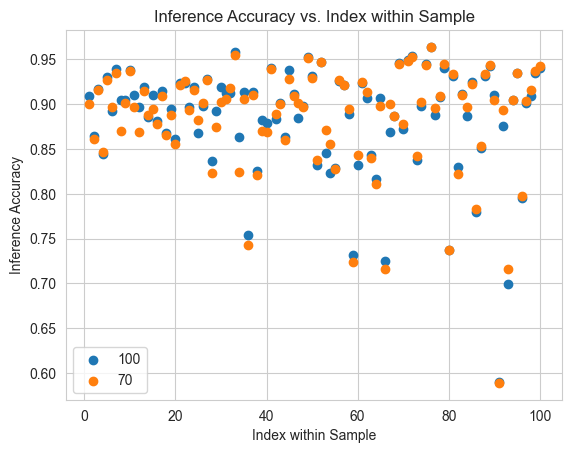

In [417]:
card_names = ['a100', 'k80', 'rtx2080']
epochs = [10, 30, 50, 100]
colormap = plt.cm.get_cmap('Set1', len(card_names))

def create_accuracy_history_plot(card_name, epoch):
    subset = new_dataframe[(new_dataframe['card_name'] == card_name) & (new_dataframe['epoch'] == epoch)]

    # Get unique card names
    unique_card_names = subset['card_name'].unique()

    # Plot for each card name
    for card_name in unique_card_names:
        card_subset = subset[subset['card_name'] == card_name]
        x = np.arange(1, len(card_subset['inference.accuracy'].iloc[0]) + 1)
        y = card_subset['inference.accuracy'].iloc[0]
        plt.scatter(x, y, label=epoch)

    plt.xlabel('Index within Sample')
    plt.ylabel('Inference Accuracy')
    plt.title('Inference Accuracy vs. Index within Sample')
    plt.legend()

# for card_name in card_names:
create_accuracy_history_plot('a100', 100)
create_accuracy_history_plot('a100', 70)
# create_accuracy_history_plot('a100', 50)

Shell.mkdir('./images')
# name = key.replace('.', '-')
save_image(plt, f"./images/inference-accuracy")

plt.show()


In [418]:
card_names = ['a100', 'k80', 'rtx2080']
epochs = [10, 30, 50, 100]
colormap = plt.cm.get_cmap('Set1', len(card_names))

def select_accuracy_history(card_name, epoch):
    subset = new_dataframe[(new_dataframe['card_name'] == card_name) & (new_dataframe['epoch'] == epoch) & (new_dataframe['timer'] == 'total')]
    subset = subset.sort_values(by='inference.accuracy', ascending=True)

    # Get unique card names
    unique_card_names = subset['card_name'].unique()
    return subset

empty = pd.DataFrame()
sb = select_accuracy_history('a100', 100)
sb2 = select_accuracy_history('a100', 70)
empty = pd.concat([sb, sb2], ignore_index=True)
empty = empty.reset_index()
# empty = empty.concat([sb, sb2])

wanted = ['index', 'job', 'epoch', 'card_name', 'inference.accuracy']
drop = [x for x in empty.columns if x not in wanted]
print(drop)

for key in drop:

    empty.drop(key, inplace=True, axis=1)
# for key in list(empty.columns):
#     if str(key) not in :
#         empty.drop(key, inplace=True)

print('heres empty')
display(empty)

['timer', 'time', 'repeat', 'jobid', 'training.samples', 'training.accuracy', 'training.loss', 'training.val_loss', 'training.val_accuracy', 'training.history.accuracy', 'training.history.loss', 'training.history.val_loss', 'training.history.val_accuracy', 'inference.avg_accuracy', 'inference_analyze.number', 'inference_analyze.bs', 'inference_analyze.nodes', 'inference_analyze.gpus', 'inference_analyze.time_per_inference']
heres empty


,index,job,epoch,card_name,inference.accuracy
0,0,a100 100 1 cloudmask,100,a100,"[0.9090511111111111, 0.8642083333333334, 0.917..."
1,1,a100 70 1 cloudmask,70,a100,"[0.899965, 0.8610055555555556, 0.9160277777777..."


In [419]:
# Transpose the "inference.accuracy" column values
transposed_100 = empty[empty['epoch'] == 100].explode('inference.accuracy').reset_index(drop=True)
transposed_100.columns = [f"{col}_100" for col in transposed_100.columns]

transposed_70 = empty[empty['epoch'] == 70].explode('inference.accuracy').reset_index(drop=True)
transposed_70.columns = [f"{col}_70" for col in transposed_70.columns]

transposed = pd.concat([transposed_70, transposed_100], axis=1)
transposed.sort_values('inference.accuracy_100', inplace=True, ascending=False)
transposed.drop(['card_name_100', 'card_name_70', 'job_70', 'job_100', 'index_70', 'index_100'], inplace=True, axis=1)

transposed = transposed.rename_axis('index').reset_index()
transposed['good_index'] = transposed.index

transposed

,index,epoch_70,inference.accuracy_70,epoch_100,inference.accuracy_100,good_index
0,75,70,0.963724,100,0.96371,0
1,32,70,0.954737,100,0.957952,1
2,71,70,0.952736,100,0.954155,2
3,48,70,0.951569,100,0.952238,3
4,70,70,0.948237,100,0.94873,4
...,...,...,...,...,...,...
95,79,70,0.737201,100,0.737034,95
96,58,70,0.723963,100,0.731594,96
97,65,70,0.715878,100,0.724981,97
98,92,70,0.715628,100,0.699426,98


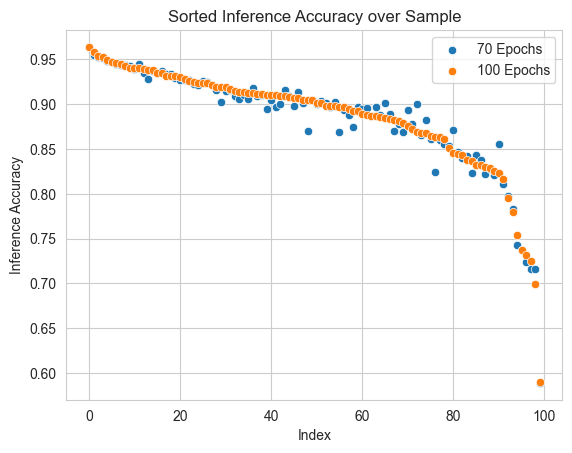

In [420]:
# sns.scatterplot(data=transposed, x='index', y='inference_accuracy', hue='card_name_70')
sns.scatterplot(transposed, x='good_index', y='inference.accuracy_70', label='70 Epochs')
sns.scatterplot(transposed, x='good_index', y='inference.accuracy_100', label='100 Epochs')
# transposed.scatter(x='index', y='inference_accuracy_70')
# transposed.scatter(x='index', y='inference_accuracy_100')
# Set the x-axis label
plt.xlabel('Index')
# Set the y-axis label
plt.ylabel('Inference Accuracy')
plt.title('Sorted Inference Accuracy over Sample')
plt.legend()

Shell.mkdir('./images')
# name = key.replace('.', '-')
save_image(plt, f"./images/spectrum-inference-accuracy")

plt.show()

In [421]:
# create copy
df_copy = new_dataframe #.sort_values('')
wanted = ['index', 'job', 'epoch', 'timer', 'time', 'repeat', 'card_name', 'training.accuracy', 'training.loss', 'training.val_loss', 'training.val_accuracy', 'inference.avg_accuracy']
drop = [x for x in df_copy.columns if x not in wanted]

for key in drop:
    df_copy.drop(key, inplace=True, axis=1)
df_copy

C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_38028\3549819821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.drop(key, inplace=True, axis=1)
C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_38028\3549819821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.drop(key, inplace=True, axis=1)
C:\Users\Sledgehammer\AppData\Local\Temp\ipykernel_38028\3549819821.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
1,a100 100 1 cloudmask,training block,4156.877,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
2,a100 100 1 cloudmask,training,4156.875,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
3,a100 100 1 cloudmask,loaddata,4.857,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
4,a100 100 1 cloudmask,training_on_mutiple_GPU,4151.475,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
...,...,...,...,...,...,...,...,...,...,...,...
166,rtx2080 70 1 cloudmask,training_on_mutiple_GPU,8922.666,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
167,rtx2080 70 1 cloudmask,inference block,92.558,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
168,rtx2080 70 1 cloudmask,inference,0.011,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
169,rtx2080 70 1 cloudmask,load model,0.249,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528


In [422]:
df_copy = df_copy.loc[df_copy['timer'] == 'total']
df_copy

,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
9,a100 10 1 cloudmask,total,728.088,10,a100,1,0.832312,0.343629,0.370266,0.819647,0.817071
18,a100 2 1 cloudmask,total,647.140,2,a100,1,0.799343,0.388641,0.402972,0.763289,0.808729
27,a100 30 1 cloudmask,total,1495.592,30,a100,1,0.872654,0.284226,0.306820,0.866642,0.879109
36,a100 50 1 cloudmask,total,3064.002,50,a100,1,0.880052,0.271738,0.278948,0.878290,0.885061
45,a100 70 1 cloudmask,total,3102.653,70,a100,1,0.886616,0.257775,0.276179,0.883284,0.884767
54,k80 10 1 cloudmask,total,7227.690,10,k80,1,0.823546,0.354994,0.380437,0.821543,0.822653
63,k80 2 1 cloudmask,total,2159.472,2,k80,1,0.796934,0.392451,0.402417,0.774141,0.816317
72,p100 10 1 cloudmask,total,2642.111,10,p100,1,0.810620,0.366653,0.394432,0.759318,0.807343
81,p100 2 1 cloudmask,total,973.709,2,p100,1,0.802113,0.389560,0.403058,0.760519,0.810091


In [423]:
parameters = [('training.loss', True),
    ('training.val_loss', True),
    ('training.val_accuracy', False),
    ('inference.avg_accuracy', False)]
# leader = df_copy.sort_values('training.accuracy', ascending=False)
for key, ascending in parameters:

    print('leaderboard', key)
    leader = df_copy.sort_values(key, ascending=ascending)
    display(leader)

leaderboard training.loss


,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
117,rtx2080 100 1 cloudmask,total,12809.693,100,rtx2080,1,0.889827,0.248761,0.266637,0.883383,0.890432
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
162,rtx2080 70 1 cloudmask,total,9021.470,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
45,a100 70 1 cloudmask,total,3102.653,70,a100,1,0.886616,0.257775,0.276179,0.883284,0.884767
108,p100 70 1 cloudmask,total,14695.467,70,p100,1,0.882744,0.264044,0.287152,0.875643,0.886373
153,rtx2080 50 1 cloudmask,total,10564.898,50,rtx2080,1,0.880296,0.270595,0.291582,0.873009,0.884003
36,a100 50 1 cloudmask,total,3064.002,50,a100,1,0.880052,0.271738,0.278948,0.878290,0.885061
144,rtx2080 30 1 cloudmask,total,6527.227,30,rtx2080,1,0.873420,0.282001,0.301372,0.861411,0.880867
99,p100 50 1 cloudmask,total,10902.162,50,p100,1,0.875247,0.283393,0.305439,0.871354,0.874926
27,a100 30 1 cloudmask,total,1495.592,30,a100,1,0.872654,0.284226,0.306820,0.866642,0.879109


leaderboard training.val_loss


,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
117,rtx2080 100 1 cloudmask,total,12809.693,100,rtx2080,1,0.889827,0.248761,0.266637,0.883383,0.890432
162,rtx2080 70 1 cloudmask,total,9021.470,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
45,a100 70 1 cloudmask,total,3102.653,70,a100,1,0.886616,0.257775,0.276179,0.883284,0.884767
36,a100 50 1 cloudmask,total,3064.002,50,a100,1,0.880052,0.271738,0.278948,0.878290,0.885061
108,p100 70 1 cloudmask,total,14695.467,70,p100,1,0.882744,0.264044,0.287152,0.875643,0.886373
153,rtx2080 50 1 cloudmask,total,10564.898,50,rtx2080,1,0.880296,0.270595,0.291582,0.873009,0.884003
90,p100 30 1 cloudmask,total,8489.737,30,p100,1,0.869366,0.288599,0.294026,0.874427,0.883618
144,rtx2080 30 1 cloudmask,total,6527.227,30,rtx2080,1,0.873420,0.282001,0.301372,0.861411,0.880867
99,p100 50 1 cloudmask,total,10902.162,50,p100,1,0.875247,0.283393,0.305439,0.871354,0.874926


leaderboard training.val_accuracy


,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
162,rtx2080 70 1 cloudmask,total,9021.470,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
117,rtx2080 100 1 cloudmask,total,12809.693,100,rtx2080,1,0.889827,0.248761,0.266637,0.883383,0.890432
45,a100 70 1 cloudmask,total,3102.653,70,a100,1,0.886616,0.257775,0.276179,0.883284,0.884767
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
36,a100 50 1 cloudmask,total,3064.002,50,a100,1,0.880052,0.271738,0.278948,0.878290,0.885061
108,p100 70 1 cloudmask,total,14695.467,70,p100,1,0.882744,0.264044,0.287152,0.875643,0.886373
90,p100 30 1 cloudmask,total,8489.737,30,p100,1,0.869366,0.288599,0.294026,0.874427,0.883618
153,rtx2080 50 1 cloudmask,total,10564.898,50,rtx2080,1,0.880296,0.270595,0.291582,0.873009,0.884003
99,p100 50 1 cloudmask,total,10902.162,50,p100,1,0.875247,0.283393,0.305439,0.871354,0.874926
27,a100 30 1 cloudmask,total,1495.592,30,a100,1,0.872654,0.284226,0.306820,0.866642,0.879109


leaderboard inference.avg_accuracy


,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
117,rtx2080 100 1 cloudmask,total,12809.693,100,rtx2080,1,0.889827,0.248761,0.266637,0.883383,0.890432
108,p100 70 1 cloudmask,total,14695.467,70,p100,1,0.882744,0.264044,0.287152,0.875643,0.886373
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
36,a100 50 1 cloudmask,total,3064.002,50,a100,1,0.880052,0.271738,0.278948,0.878290,0.885061
45,a100 70 1 cloudmask,total,3102.653,70,a100,1,0.886616,0.257775,0.276179,0.883284,0.884767
162,rtx2080 70 1 cloudmask,total,9021.470,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
153,rtx2080 50 1 cloudmask,total,10564.898,50,rtx2080,1,0.880296,0.270595,0.291582,0.873009,0.884003
90,p100 30 1 cloudmask,total,8489.737,30,p100,1,0.869366,0.288599,0.294026,0.874427,0.883618
144,rtx2080 30 1 cloudmask,total,6527.227,30,rtx2080,1,0.873420,0.282001,0.301372,0.861411,0.880867
27,a100 30 1 cloudmask,total,1495.592,30,a100,1,0.872654,0.284226,0.306820,0.866642,0.879109


In [424]:
new_dataframe

,job,timer,time,epoch,card_name,repeat,training.accuracy,training.loss,training.val_loss,training.val_accuracy,inference.avg_accuracy
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
1,a100 100 1 cloudmask,training block,4156.877,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
2,a100 100 1 cloudmask,training,4156.875,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
3,a100 100 1 cloudmask,loaddata,4.857,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
4,a100 100 1 cloudmask,training_on_mutiple_GPU,4151.475,100,a100,1,0.888343,0.252271,0.269165,0.882908,0.885809
...,...,...,...,...,...,...,...,...,...,...,...
166,rtx2080 70 1 cloudmask,training_on_mutiple_GPU,8922.666,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
167,rtx2080 70 1 cloudmask,inference block,92.558,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
168,rtx2080 70 1 cloudmask,inference,0.011,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528
169,rtx2080 70 1 cloudmask,load model,0.249,70,rtx2080,1,0.885524,0.257720,0.267725,0.886642,0.884528


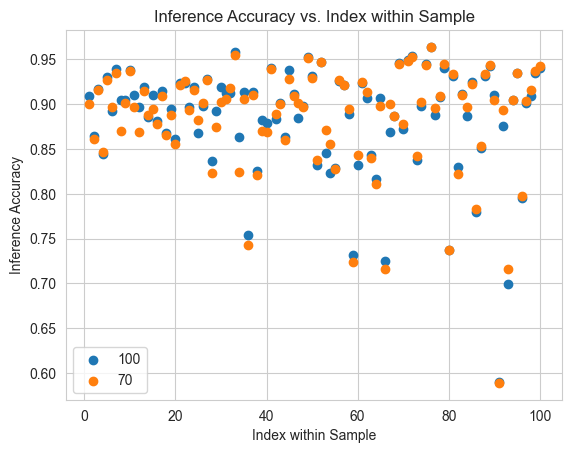

In [425]:

def create_accuracy_history_plot(card_name, epoch):
    subset = full_df[(full_df['card_name'] == card_name) & (full_df['epoch'] == epoch)]

    subset = subset.sort_values(by='inference.accuracy', ascending=True)
    # Get unique card names
    unique_card_names = subset['card_name'].unique()

    # Plot for each card name
    for card_name in unique_card_names:
        card_subset = subset[subset['card_name'] == card_name]
        x = np.arange(1, len(card_subset['inference.accuracy'].iloc[0]) + 1)
        y = card_subset['inference.accuracy'].iloc[0]
        plt.scatter(x, y, label=epoch)


    plt.xlabel('Index within Sample')
    plt.ylabel('Inference Accuracy')
    plt.title('Inference Accuracy vs. Index within Sample')
    plt.legend()

# for card_name in card_names:
create_accuracy_history_plot('a100', 100)
create_accuracy_history_plot('a100', 70)
# create_accuracy_history_plot('a100', 50)


plt.show()



In [426]:
# inference analysis.
df_ia = full_df.loc[full_df['card_name'] == 'a100']
df_ia

,job,timer,time,epoch,card_name,repeat,jobid,training.samples,training.accuracy,training.loss,...,training.history.loss,training.history.val_loss,training.history.val_accuracy,inference.avg_accuracy,inference.accuracy,inference_analyze.number,inference_analyze.bs,inference_analyze.nodes,inference_analyze.gpus,inference_analyze.time_per_inference
0,a100 100 1 cloudmask,total,4301.555,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
1,a100 100 1 cloudmask,training block,4156.877,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
2,a100 100 1 cloudmask,training,4156.875,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
3,a100 100 1 cloudmask,loaddata,4.857,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
4,a100 100 1 cloudmask,training_on_mutiple_GPU,4151.475,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
5,a100 100 1 cloudmask,inference block,143.621,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
6,a100 100 1 cloudmask,inference,0.022,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
7,a100 100 1 cloudmask,load model,0.214,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
8,a100 100 1 cloudmask,read inference files,0.005,100,a100,1,51472126,970,0.888343,0.252271,...,"[0.42170780897140503, 0.39145514369010925, 0.3...","[0.40987929701805115, 0.4118395149707794, 0.40...","[0.7581854462623596, 0.7678648233413696, 0.777...",0.885809,"[0.9090511111111111, 0.8642083333333334, 0.917...",100,32,1,1,1.44
9,a100 10 1 cloudmask,total,728.088,10,a100,1,51472122,970,0.832312,0.343629,...,"[0.4247799813747406, 0.3910360038280487, 0.387...","[0.4116460382938385, 0.4004575312137604, 0.422...","[0.760211706161499, 0.763192355632782, 0.77623...",0.817071,"[0.8822294444444444, 0.8532766666666667, 0.894...",100,32,1,1,1.40


In [427]:
epoch = 100
card_name = 'a100'
repeat = 1
# Plotting each card_name separately
# for card_name in unique_card_names:

def create_history_plot(card_name, epoch, repeat, key):

    subset = full_df[(full_df['card_name'] == card_name) & (full_df['epoch'] == epoch) & (full_df['repeat'] == repeat)]
    # display(subset)
    y = subset[key].values[0]  # Extracting the list of accuracy values
    x = range(1, len(y) + 1)  # x-axis represents the index within the list (1-100)
    plt.plot(x, y, label=card_name.upper())

    # Set the labels and title
    plt.xlabel('Epoch')
    plt.ylabel(key.title().replace('.', ' ').replace('_', ' '))
    plt.title(f'{key.title().replace(".", " ").replace("_", " ")} vs. Epoch: Up to 100')

    # Add a legend
    # plt.legend()

    # Show the plot
    # plt.show()

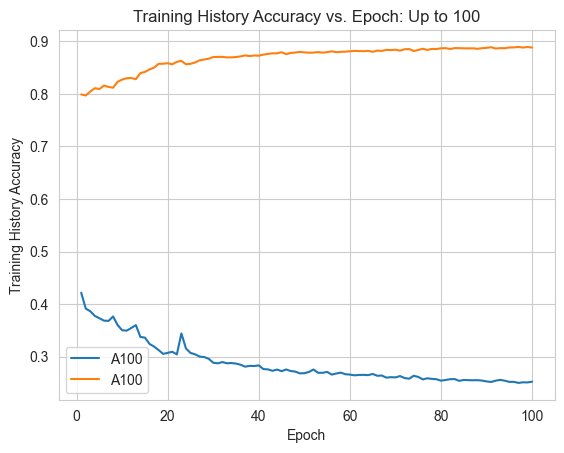

In [428]:

create_history_plot(card_name='a100', epoch=100, repeat=1, key='training.history.loss')
create_history_plot(card_name='a100', epoch=100, repeat=1, key='training.history.accuracy')
# create_history_plot(card_name='rtx2080', epoch=100, repeat=1)
plt.legend()
plt.show()

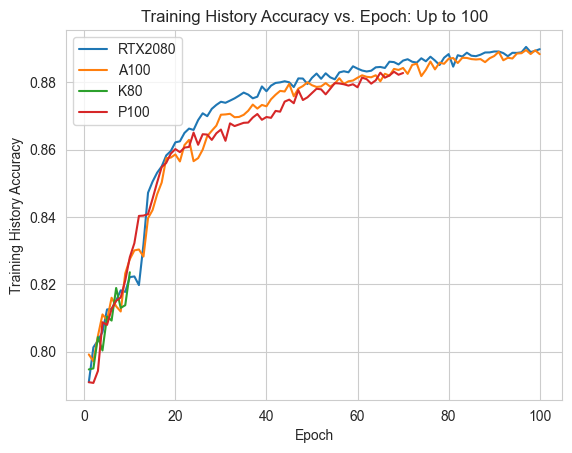

In [429]:

create_history_plot(card_name='rtx2080', epoch=100, repeat=1, key='training.history.accuracy')
create_history_plot(card_name='a100', epoch=100, repeat=1, key='training.history.accuracy')
create_history_plot(card_name='k80', epoch=10, repeat=1, key='training.history.accuracy')
create_history_plot(card_name='p100', epoch=70, repeat=1, key='training.history.accuracy')
# create_history_plot(card_name='rtx2080', epoch=100, repeat=1)
plt.legend()

Shell.mkdir('./images')
# name = key.replace('.', '-')
save_image(plt, f"./images/training-history-all-cards")

plt.show()

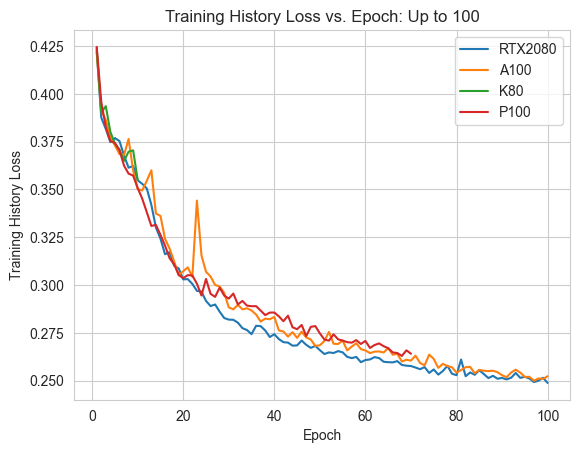

In [430]:
create_history_plot(card_name='rtx2080', epoch=100, repeat=1, key='training.history.loss')
create_history_plot(card_name='a100', epoch=100, repeat=1, key='training.history.loss')
create_history_plot(card_name='k80', epoch=10, repeat=1, key='training.history.loss')
create_history_plot(card_name='p100', epoch=70, repeat=1, key='training.history.loss')
# create_history_plot(card_name='rtx2080', epoch=100, repeat=1)
plt.legend()

Shell.mkdir('./images')
# name = key.replace('.', '-')
save_image(plt, f"./images/training-history-loss-all-cards")

plt.show()

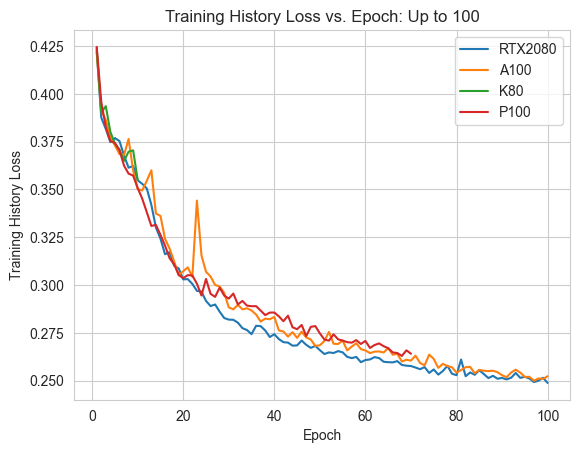

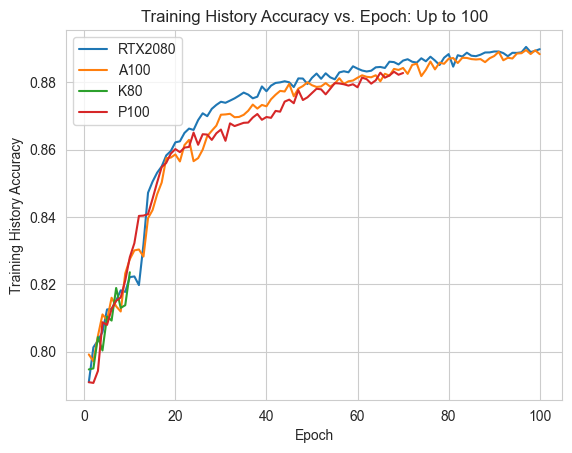

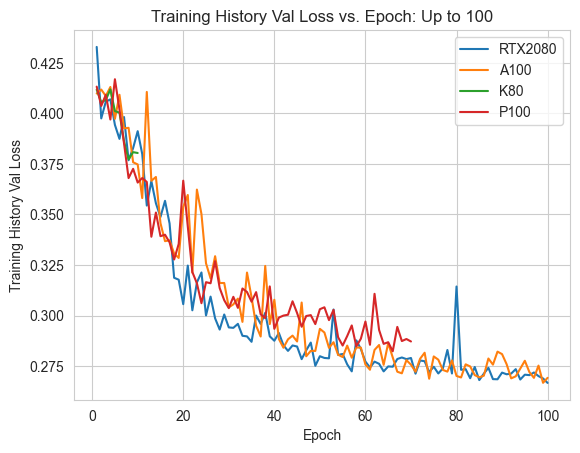

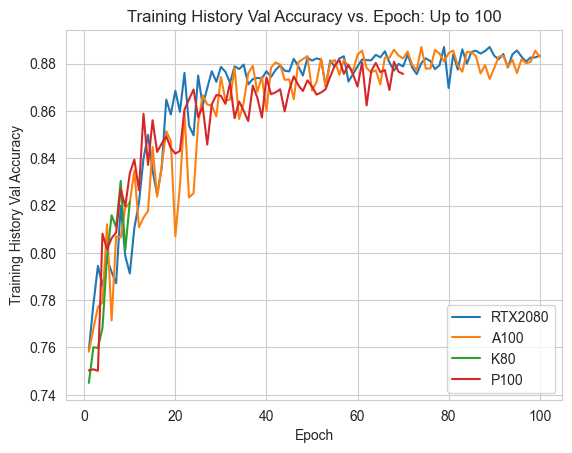

In [431]:
for key in ['training.history.loss', 'training.history.accuracy', 'training.history.val_loss', 'training.history.val_accuracy']:

    create_history_plot(card_name='rtx2080', epoch=100, repeat=1, key=key)
    create_history_plot(card_name='a100', epoch=100, repeat=1, key=key)
    create_history_plot(card_name='k80', epoch=10, repeat=1, key=key)
    create_history_plot(card_name='p100', epoch=70, repeat=1, key=key)
    # create_history_plot(card_name='rtx2080', epoch=100, repeat=1)

    plt.legend()

    Shell.mkdir('./images')
    name = key.replace('.', '-')
    save_image(plt, f"./images/{name}")

    plt.show()



In [432]:
df['training.history.loss']
df['training.history.accuracy']
df['training.history.val_loss']
df['training.history.val_accuracy']
df['inference.accuracy']

0    [0.8976655555555556, 0.8677983333333333, 0.908...
1    [0.8976655555555556, 0.8677983333333333, 0.908...
2    [0.8976655555555556, 0.8677983333333333, 0.908...
3    [0.8976655555555556, 0.8677983333333333, 0.908...
4    [0.8976655555555556, 0.8677983333333333, 0.908...
5    [0.8976655555555556, 0.8677983333333333, 0.908...
6    [0.8976655555555556, 0.8677983333333333, 0.908...
7    [0.8976655555555556, 0.8677983333333333, 0.908...
8    [0.8976655555555556, 0.8677983333333333, 0.908...
Name: inference.accuracy, dtype: object

In [433]:
"""
+-------------------------+----------+---------+
| Name                    | Status   |    Time |
|-------------------------+----------+---------+
| total                   | ok       | 203.461 |
| init                    | ok       |   0     |
| number_of_ranks         | ok       |   0     |
| number_of_nodes         | ok       |   0     |
| version                 | ok       |   0     |
| training block          | ok       | 152.313 |
| training                | ok       | 152.299 |
| loaddata                | ok       |   1.766 |
| training_on_mutiple_GPU | ok       | 148.641 |
| inference block         | ok       |  51.018 |
| inference               | ok       |   0.006 |
| load model              | ok       |   0.196 |
| read inference files    | ok       |   0.009 |
| result                  | ok       |   0     |
| run_stop                | ok       |   0     |
| submission_status       | ok       |   0     |
+-------------------------+----------+---------+
"""

addons = pd.DataFrame(
    [
        {'timer':'total', 'time': 203.461, 'job': 'rtx3090 desktop'},
        {'timer':'total', 'time': 660.296, 'job': 'a100 greene'}
    ])
total = pd.concat([total, addons], ignore_index=True)


total

TypeError: cannot concatenate object of type '<class 'float'>'; only Series and DataFrame objs are valid

In [ ]:
total = total.sort_values(by=['time'], ascending=False)

In [ ]:
def save_image(p, name, dpi=300):
    # Shell.mkdir(directory)
    p.figure.savefig(f"{name}.svg", bbox_inches="tight")
    p.figure.savefig(f"{name}.png", bbox_inches="tight", dpi=dpi)
    p.figure.savefig(f"{name}.pdf", bbox_inches="tight")
    p.figure.savefig(f"{name}.tiff", bbox_inches="tight")

In [ ]:
total

In [ ]:
def plot_by_timer(data, timer):
    plt.xticks(rotation=45)
    p = sns.barplot(data, x="job", y="time")
    p.set(xlabel = "GPU", ylabel = "Time in s")
    p.set_title(f"{timer} Runtime Comparision of Rivanna GPUs")
    return p

p = plot_by_timer(total, "total")

In [ ]:
if not os.path.isdir('./images'):
    Shell.mkdir('./images')
save_image(p, "./images/comparision-epoch-1", dpi=300)

In [ ]:
training = get_by_timer(data, "training block")
plot_by_timer(training, "training block")

training

In [ ]:
inference = get_by_timer(data, "inference block")
plot_by_timer(inference, "inference block")

inference

In [ ]:

_data = data[data['timer'].isin(["total","training block","inference block"])]
_data = _data.sort_values(by=['time'], ascending=False)
_data = _data.reset_index()
_data["job"] = _data["job"].apply(simplify_job)
_data = _data.drop(columns=["index"])

# _data["job"] = _data["job"].apply(simplify_job)
# _data = _data.drop(columns=["index"])

_data

In [ ]:
def get(name):
    content = data[data.timer.isin([name])]['time'].tolist()
    return {name: content}


#plt.xticks(rotation=45)
#p.set(xlabel = "GPU", ylabel = "Time in s")
#p.set_title("Runtime Comparision of Rivanna GPUs")


stacked = pd.DataFrame(
    get('job'), get('total'), get('training block')
)

stacked

stacked.set_index('job').plot(kind='bar', stacked=True, color=['blue', 'red', 'orange'])

In [ ]:
# Import statements
from cloudmesh.common.util import readfile
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


import sys
import os


In [ ]:
try:
    Shell.rm('megalode.log')
except:
    pass
try:
    Shell.run(f'cat {dirname} * >> megalode.log')
except Exception as e:
    print(e.output)

In [ ]:

mlperf_file = 'megalode.log'
# Read file
content = readfile(mlperf_file).splitlines()

# Create dataframes
train_df = pd.DataFrame(columns = ['Run','Epochs','Train Accuracy','Train Loss','Validation Accuracy','Validation Loss'])
test_df = pd.DataFrame(columns = ['Epochs', 'Test Accuracy'])

run = 0
# Appending accuracies to the dataframe
for line in content:
    # Locate Result line
    if ':::MLLOG' in line and '"key": "result"' in line and 'training' in line:
        # String to a dict using json.loads
        # print(line)
        d = json.loads(line.split(":::MLLOG ")[1])

        # Extracting values
        train_acc = eval(d["value"])["training"]["history"]["accuracy"]
        # print(train_acc)
        train_loss = eval(d["value"])["training"]["history"]["loss"]
        val_acc = eval(d["value"])["training"]["history"]["val_accuracy"]
        val_loss = eval(d["value"])["training"]["history"]["val_loss"]
        test_acc = eval(d["value"])["inference"]["avg_accuracy"]

        # Checking length of the lists
        epochs = len(train_acc)
        if epochs == len(train_loss) and epochs == len(val_acc) and epochs == len(val_loss):

            # Appending to dataframe
            for i in range(epochs):

                train_df.loc[len(train_df.index)] = ["Run " + str(run+1), i + 1, train_acc[i], train_loss[i], val_acc[i], val_loss[i]]
            test_df.loc[len(test_df.index)] = [epochs, test_acc]
        else:
            print("The values for accuracies and losses don't have same length.")
            raise ValueError

        run+=1

# print(train_df)
# print(test_df)

# Creating images directory
if not os.path.exists("images"):
    os.makedirs("images")
train_df

In [ ]:

# Plotting the graphs
acc_plot = sns.lineplot(data = train_df , x = "Epochs", y = "Train Accuracy", label = "Train Accuracy")
acc_plot = sns.lineplot(data = train_df , x = "Epochs", y = "Validation Accuracy", label = "Validation Accuracy")
acc_plot = sns.lineplot(data = test_df , x = "Epochs" , y = "Test Accuracy", label = "Test Accuracy")
acc_plot.set(xlabel = "Epochs", ylabel = "Accuracies")
acc_plot.set_title("Epochs vs. Accuracies")

In [ ]:

# Saving figure in different formats
acc_plot.figure.savefig("images/epoch_vs_accuracy.svg")
acc_plot.figure.savefig("images/epoch_vs_accuracy.png", dpi=300)
acc_plot.figure.savefig("images/epoch_vs_accuracy.pdf")

# Clearing the figure
acc_plot.figure.clf()

loss_plot = sns.lineplot(data = train_df , x = "Epochs", y = "Train Loss", label = "Train Loss")
loss_plot = sns.lineplot(data = train_df , x = "Epochs", y = "Validation Loss", label = "Validation Loss")
loss_plot.set(xlabel = "Epochs", ylabel = "Losses")
loss_plot.set_title("Epochs vs. Losses")

loss_plot.figure.savefig("images/epoch_vs_loss.svg")
loss_plot.figure.savefig("images/epoch_vs_loss.png", dpi = 300)
loss_plot.figure.savefig("images/epoch_vs_loss.pdf")

loss_plot.figure.clf()

# Plotting different runs seperately
if(run>1):
    sns.color_palette("pastel")
    train_acc_plot = sns.lineplot(data = train_df, y = "Train Accuracy", x = "Epochs", hue = "Run", palette="pastel")
    train_acc_plot.set_title("Train Accuracies for different runs")
    train_acc_plot.set(xlabel = "Epochs", ylabel = "Train Accuracy")

    train_acc_plot.figure.savefig("images/train_accuracy_diff_runs.svg")
    train_acc_plot.figure.savefig("images/train_accuracy_diff_runs.png", dpi=300)
    train_acc_plot.figure.savefig("images/train_accuracy_diff_runs.pdf")

    train_acc_plot.figure.clf()

    train_loss_plot = sns.lineplot(data = train_df, y = "Train Loss", x = "Epochs", hue = "Run", palette="pastel")
    train_loss_plot.set_title("Train Losses for different runs")
    train_loss_plot.set(xlabel = "Epochs", ylabel = "Train Loss")

    train_loss_plot.figure.savefig("images/train_loss_diff_runs.svg")
    train_loss_plot.figure.savefig("images/train_loss_diff_runs.png", dpi=300)
    train_loss_plot.figure.savefig("images/train_loss_diff_runs.pdf")

    train_loss_plot.figure.clf()


    val_acc_plot = sns.lineplot(data = train_df, y = "Validation Accuracy", x = "Epochs", hue = "Run", palette="pastel")
    val_acc_plot.set_title("Validation Accuracies for different runs")
    val_acc_plot.set(xlabel = "Epochs", ylabel = "Validation Accuracy")

    val_acc_plot.figure.savefig("images/validation_accuracy_diff_runs.svg")
    val_acc_plot.figure.savefig("images/validation_accuracy_diff_runs.png", dpi=300)
    val_acc_plot.figure.savefig("images/validation_accuracy_diff_runs.pdf")

    val_acc_plot.figure.clf()

    val_loss_plot = sns.lineplot(data = train_df, y = "Validation Loss", x = "Epochs", hue = "Run", palette="pastel")
    val_loss_plot.set_title("Validation Losses for different runs")
    val_loss_plot.set(xlabel = "Epochs", ylabel = "Validation Loss")

    val_loss_plot.figure.savefig("images/validation_loss_diff_runs.svg")
    val_loss_plot.figure.savefig("images/validation_loss_diff_runs.png", dpi=300)
    val_loss_plot.figure.savefig("images/validation_loss_diff_runs.pdf")

    val_loss_plot.figure.clf()


In [ ]:

def epoch_vs_perf(cloudmask_file):

    # Create lists
    time_for_training = []
    time_for_inference = []
    epochs = []

    # Read contents in the file
    content = readfile(cloudmask_file).splitlines()
    for line in content:
        split_line = line.split(",")
        for vals in split_line:
            if "CloudMask training" in split_line and 'time_per' in vals.strip():
                time_for_training.append(float(vals.split("=")[1]))
            elif "CloudMask inference" in split_line and 'time_per' in vals.strip():
                time_for_inference.append(float(vals.split("=")[1]))

            if "epochs" in vals.strip():
                epochs.append(int(vals.split("=")[1]))

    if len(epochs) == len(time_for_training) and len(epochs) == len(time_for_inference):
        # Construct dataframe
        train_time =  pd.DataFrame(columns = ['Epochs','Average Time Per Epoch (ms)'])
        test_time =  pd.DataFrame(columns = ['Epochs','Average Time Per Epoch (ms)'])

        # Appending values to dataframe
        #print(time_for_training)
        #print(time_for_inference)
        #print(epochs)
        for i in range(len(epochs)):
            train_time.loc[len(train_time.index)] = [epochs[i], time_for_training[i]]
            test_time.loc[len(test_time.index)] = [epochs[i], time_for_inference[i]]

        # Plotting the graphs
        train_time_plot = sns.lineplot(data = train_time , y = "Epochs", x = "Average Time Per Epoch (ms)", label = "Train Avg. time per epoch")
        train_time_plot.set(xlabel = "Epochs", ylabel = "Average Time Per Epoch (ms)")
        train_time_plot.set_title("Epochs vs. Avg. time per epoch")

        train_time_plot.figure.savefig("images/epoch_vs_train_time.svg")
        train_time_plot.figure.savefig("images/epoch_vs_train_time.png", dpi = 300)
        train_time_plot.figure.savefig("images/epoch_vs_train_time.pdf")

        train_time_plot.figure.clf()

        test_time_plot = sns.lineplot(data = test_time , y = "Epochs", x = "Average Time Per Epoch (ms)", label = "Inference Avg. Time per epoch")
        test_time_plot.set(xlabel = "Epochs", ylabel = "Average Time Per Epoch (ms)")
        test_time_plot.set_title("Epochs vs. Avg. time per epoch")

        test_time_plot.figure.savefig("images/epoch_vs_test_time.svg")
        test_time_plot.figure.savefig("images/epoch_vs_test_time.png", dpi = 300)
        test_time_plot.figure.savefig("images/epoch_vs_test_time.pdf")

        test_time_plot.figure.clf()

    else:
        print("The Cloudmask file has extra unsuccessful attempt values.")
        return